# Notebook 04 — ZuCo Models (v1+v2): KEC × Dataset/Task (v4.3, Upgraded)

OLS (clustered SE), FDR, MixedLM (Subject + vc SentenceID), Bootstrap (joblib), partial plots & EEG trends.


In [1]:
import os, time, warnings, re
from pathlib import Path
import numpy as np, pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
SEED=42; np.random.seed(SEED)
FIG_DIR=Path('figures/metrics'); FIG_DIR.mkdir(parents=True, exist_ok=True)
PROC_DIR=Path('../data/processed'); PROC_DIR.mkdir(parents=True, exist_ok=True)
RPT_DIR=Path('reports'); RPT_DIR.mkdir(parents=True, exist_ok=True)
def heartbeat(m): print(f"[{time.strftime('%H:%M:%S')}] {m}")
def norm_token(s):
    if not isinstance(s,str): return s
    s=s.lower(); s=re.sub(r'[\W_]+','',s); return s
heartbeat('Env ready')


[19:56:14] Env ready


In [2]:
zuco=pd.read_csv(PROC_DIR/'zuco_aligned.csv') if (PROC_DIR/'zuco_aligned.csv').exists() else pd.DataFrame()
kec=pd.read_csv(PROC_DIR/'kec'/'metrics_en.csv') if (PROC_DIR/'kec'/'metrics_en.csv').exists() else pd.DataFrame()
print(f"PROC_DIR: {PROC_DIR}")
print(f"ZuCo path: {PROC_DIR/'zuco_aligned.csv'}")
print(f"ZuCo exists: {(PROC_DIR/'zuco_aligned.csv').exists()}")
print(f"KEC path: {PROC_DIR/'kec'/'metrics_en.csv'}")
print(f"KEC exists: {(PROC_DIR/'kec'/'metrics_en.csv').exists()}")
for d in (zuco,kec):
    if len(d)>0: d.columns=[c.strip() for c in d.columns]
if len(zuco)>0: zuco['token_norm']=zuco.get('Word', zuco.get('word','')).astype(str).map(norm_token)
if len(kec)>0:
    src_word='node' if 'node' in kec.columns else ('word' if 'word' in kec.columns else ('Word' if 'Word' in kec.columns else None))
    if src_word: kec['token_norm']=kec[src_word].astype(str).map(norm_token)
merged = zuco.merge(kec[['token_norm','entropy','avg_curvature','coherence']].rename(columns={'avg_curvature':'curvature'}) if len(kec)>0 and all(col in kec.columns for col in ['token_norm','entropy','avg_curvature','coherence']) else pd.DataFrame(),
                    on='token_norm', how='left', suffixes=('','_kec')) if len(zuco)>0 and len(kec)>0 and 'token_norm' in zuco.columns and 'token_norm' in kec.columns else pd.DataFrame()
heartbeat(f'Merged shape: {merged.shape if len(merged)>0 else "N/A"}')


/tmp/ipykernel_680912/4165890336.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  zuco=pd.read_csv(PROC_DIR/'zuco_aligned.csv') if (PROC_DIR/'zuco_aligned.csv').exists() else pd.DataFrame()


PROC_DIR: ../data/processed
ZuCo path: ../data/processed/zuco_aligned.csv
ZuCo exists: True
KEC path: ../data/processed/kec/metrics_en.csv
KEC exists: True
[19:56:14] Merged shape: (64168, 21)
[19:56:14] Merged shape: (64168, 21)


In [3]:
# Process merged data
df=merged.copy()
if len(df)>0:
    df=df.rename(columns={'LogFreq':'log_freq'})
    for resp in ('TRT','GPT'):
        if resp in df: df[f'log_{resp}']=np.log1p(df[resp])
    for cat in ('Dataset','Task','Subject','SentenceID'):
        if cat in df: df[cat]=df[cat].astype(str)
    ET_COLS=[c for c in ('FFD','GD','log_TRT','log_GPT') if c in df.columns]
    KEC_COLS=[c for c in ('entropy','curvature','coherence') if c in df.columns]
    COVS=[c for c in ('length','log_freq','surprisal') if c in df.columns]
    heartbeat(f'ET:{ET_COLS} KEC:{KEC_COLS} COVS:{COVS}')
else:
    heartbeat('No merged data to process')

[19:56:14] ET:['FFD', 'GD', 'log_TRT', 'log_GPT'] KEC:['entropy', 'curvature', 'coherence'] COVS:[]


In [4]:
# Debug data structure
print("=== DEBUG DATA STRUCTURE ===")
print(f"df shape: {df.shape}")
print(f"df columns: {list(df.columns)}")

# Check for NaN values
nan_counts = df.isnull().sum()
print(f"NaN counts per column:\n{nan_counts[nan_counts > 0]}")

# Check categorical variables
for cat in ['Dataset', 'Task', 'Subject']:
    if cat in df.columns:
        unique_vals = df[cat].unique()
        print(f"{cat} unique values: {len(unique_vals)} - {unique_vals[:5]}...")

# Check numeric columns
numeric_cols = ['FFD', 'GD', 'log_TRT', 'log_GPT', 'entropy', 'curvature', 'coherence']
for col in numeric_cols:
    if col in df.columns:
        non_nan = df[col].notna().sum()
        print(f"{col}: {non_nan} non-NaN values")

print("=== END DEBUG ===")

=== DEBUG DATA STRUCTURE ===
df shape: (64168, 23)
df columns: ['paragraph_id', 'sentence_id', 'Sentence', 'relation_type', 'Subject', 'Word', 'WordPosition', 'SentenceID', 'FFD', 'GD', 'TRT', 'GPT', 'ThetaPower', 'AlphaPower', 'Task', 'Dataset', 'control', 'token_norm', 'entropy', 'curvature', 'coherence', 'log_TRT', 'log_GPT']
NaN counts per column:
paragraph_id     35062
sentence_id      35062
relation_type    35062
Word                40
control          60724
entropy           2448
curvature         2448
coherence         2448
dtype: int64
Dataset unique values: 1 - ['v1']...
Task unique values: 1 - ['NR']...
Subject unique values: 1 - ['ZAB']...
FFD: 64168 non-NaN values
GD: 64168 non-NaN values
log_TRT: 64168 non-NaN values
log_GPT: 64168 non-NaN values
entropy: 61720 non-NaN values
curvature: 61720 non-NaN values
coherence: 61720 non-NaN values
=== END DEBUG ===


In [5]:
# Debug categorical variables variation
print("=== DEBUG CATEGORICAL VARIATION ===")
df_clean = df.dropna(subset=['FFD', 'entropy', 'curvature', 'coherence'])

print(f"After NaN removal: {len(df_clean)} rows")

for cat in ['Dataset', 'Task', 'Subject']:
    if cat in df_clean.columns:
        unique_vals = df_clean[cat].unique()
        counts = df_clean[cat].value_counts()
        print(f"{cat}: {len(unique_vals)} unique values")
        print(f"  Value counts: {dict(counts)}")

# Check if Subject has enough variation for clustering
if 'Subject' in df_clean.columns:
    subject_counts = df_clean['Subject'].value_counts()
    print(f"Subjects with data: {len(subject_counts)}")
    print(f"Min observations per subject: {subject_counts.min()}")
    print(f"Max observations per subject: {subject_counts.max()}")

print("=== END DEBUG ===")

=== DEBUG CATEGORICAL VARIATION ===
After NaN removal: 61720 rows
Dataset: 1 unique values
  Value counts: {'v1': np.int64(61720)}
Task: 1 unique values
  Value counts: {'NR': np.int64(61720)}
Subject: 1 unique values
  Value counts: {'ZAB': np.int64(61720)}
Subjects with data: 1
Min observations per subject: 61720
Max observations per subject: 61720
=== END DEBUG ===


In [6]:
# Debug KEC columns
print("=== DEBUG KEC COLUMNS ===")
if len(kec) > 0:
    print(f"KEC columns: {list(kec.columns)}")
    print(f"KEC has 'node': {'node' in kec.columns}")
    print(f"KEC has 'word': {'word' in kec.columns}")
    print(f"KEC has 'Word': {'Word' in kec.columns}")
    print(f"KEC has 'token_norm': {'token_norm' in kec.columns}")
    if 'node' in kec.columns:
        print(f"Sample node values: {kec['node'].head().tolist()}")
    if 'token_norm' in kec.columns:
        print(f"Sample token_norm values: {kec['token_norm'].head().tolist()}")
else:
    print("KEC dataframe is empty")
print("=== END DEBUG ===")

=== DEBUG KEC COLUMNS ===
KEC columns: ['node', 'entropy', 'degree', 'coherence', 'avg_curvature', 'token_norm']
KEC has 'node': True
KEC has 'word': False
KEC has 'Word': False
KEC has 'token_norm': True
Sample node values: ['there', 'position', 'place', 'point', 'true']
Sample token_norm values: ['there', 'position', 'place', 'point', 'true']
=== END DEBUG ===


In [7]:
# Debug merge columns
print("=== DEBUG MERGE COLUMNS ===")
print(f"ZuCo has token_norm: {'token_norm' in zuco.columns if len(zuco)>0 else False}")
print(f"KEC has token_norm: {'token_norm' in kec.columns if len(kec)>0 else False}")
print(f"KEC has entropy: {'entropy' in kec.columns if len(kec)>0 else False}")
print(f"KEC has curvature: {'curvature' in kec.columns if len(kec)>0 else False}")
print(f"KEC has coherence: {'coherence' in kec.columns if len(kec)>0 else False}")
print(f"KEC has avg_curvature: {'avg_curvature' in kec.columns if len(kec)>0 else False}")

# Check if all required columns exist
required_kec_cols = ['token_norm', 'entropy', 'curvature', 'coherence']
if len(kec) > 0:
    has_all_cols = all(col in kec.columns for col in required_kec_cols)
    print(f"KEC has all required columns: {has_all_cols}")
    if not has_all_cols:
        missing_cols = [col for col in required_kec_cols if col not in kec.columns]
        print(f"Missing columns: {missing_cols}")
        # Try with avg_curvature instead of curvature
        if 'avg_curvature' in kec.columns and 'curvature' not in kec.columns:
            print("Using avg_curvature instead of curvature")
else:
    print("KEC dataframe is empty")
print("=== END DEBUG ===")

=== DEBUG MERGE COLUMNS ===
ZuCo has token_norm: True
KEC has token_norm: True
KEC has entropy: True
KEC has curvature: False
KEC has coherence: True
KEC has avg_curvature: True
KEC has all required columns: False
Missing columns: ['curvature']
Using avg_curvature instead of curvature
=== END DEBUG ===


In [8]:
# Direct test of file reading
from pathlib import Path
import pandas as pd

zuco_path = Path('data/processed/zuco_aligned.csv')
kec_path = Path('data/processed/kec/metrics_en.csv')

print(f"Current directory: {Path.cwd()}")
print(f"ZuCo path: {zuco_path}")
print(f"ZuCo absolute: {zuco_path.absolute()}")
print(f"ZuCo exists: {zuco_path.exists()}")

print(f"KEC path: {kec_path}")
print(f"KEC absolute: {kec_path.absolute()}")
print(f"KEC exists: {kec_path.exists()}")

# Try reading directly
try:
    zuco_direct = pd.read_csv(str(zuco_path.absolute()))
    print(f"ZuCo direct read: {len(zuco_direct)} rows")
except Exception as e:
    print(f"Error reading ZuCo: {e}")

try:
    kec_direct = pd.read_csv(str(kec_path.absolute()))
    print(f"KEC direct read: {len(kec_direct)} rows")
except Exception as e:
    print(f"Error reading KEC: {e}")

<VSCode.Cell id="#VSC-93c1b3e1" language="python">
# Test file loading
print("=== TESTING FILE LOADING ===")

zuco_path = PROC_DIR/'zuco_aligned.csv'
kec_path = PROC_DIR/'kec'/'metrics_en.csv'

print(f"ZuCo path: {zuco_path}")
print(f"ZuCo exists: {zuco_path.exists()}")
print(f"KEC path: {kec_path}")
print(f"KEC exists: {kec_path.exists()}")

if zuco_path.exists():
    try:
        df_zuco = pd.read_csv(zuco_path)
        print(f"ZuCo loaded successfully: {len(df_zuco)} rows, {len(df_zuco.columns)} columns")
        print(f"ZuCo columns: {list(df_zuco.columns)[:5]}...")  # First 5 columns
    except Exception as e:
        print(f"Error loading ZuCo: {e}")

if kec_path.exists():
    try:
        df_kec = pd.read_csv(kec_path)
        print(f"KEC loaded successfully: {len(df_kec)} rows, {len(df_kec.columns)} columns")
        print(f"KEC columns: {list(df_kec.columns)}")
    except Exception as e:
        print(f"Error loading KEC: {e}")

print("=== END TEST ===")

<VSCode.Cell id="#VSC-19edf5cd" language="python">
# Simple debug
print("=== SIMPLE DEBUG ===")
print(f"Files exist - ZuCo: {(PROC_DIR/'zuco_aligned.csv').exists()}, KEC: {(PROC_DIR/'kec'/'metrics_en.csv').exists()}")

# Load and check data
zuco_check = pd.read_csv(PROC_DIR/'zuco_aligned.csv') if (PROC_DIR/'zuco_aligned.csv').exists() else pd.DataFrame()
kec_check = pd.read_csv(PROC_DIR/'kec'/'metrics_en.csv') if (PROC_DIR/'kec'/'metrics_en.csv').exists() else pd.DataFrame()

print(f"ZuCo loaded: {len(zuco_check)} rows")
print(f"KEC loaded: {len(kec_check)} rows")

if len(zuco_check) > 0:
    print(f"ZuCo columns: {list(zuco_check.columns)}")
    print(f"ZuCo has Word: {'Word' in zuco_check.columns}")
    
if len(kec_check) > 0:
    print(f"KEC columns: {list(kec_check.columns)}")
    print(f"KEC has word: {'word' in kec_check.columns}")

print("=== END DEBUG ===")

<VSCode.Cell id="#VSC-12ba5c77" language="python">
# Debug merge operation
print("=== DEBUG MERGE ===")
print(f"ZuCo file exists: {(PROC_DIR/'zuco_aligned.csv').exists()}")
print(f"KEC file exists: {(PROC_DIR/'kec'/'metrics_en.csv').exists()}")

if (PROC_DIR/'zuco_aligned.csv').exists():
    zuco_test = pd.read_csv(PROC_DIR/'zuco_aligned.csv')
    print(f"ZuCo shape: {zuco_test.shape}")
    print(f"ZuCo columns: {list(zuco_test.columns)}")
    print(f"ZuCo has 'Word': {'Word' in zuco_test.columns}")
    print(f"ZuCo has 'word': {'word' in zuco_test.columns}")
    print(f"ZuCo sample Word values: {zuco_test['Word'].head().tolist() if 'Word' in zuco_test.columns else 'N/A'}")

if (PROC_DIR/'kec'/'metrics_en.csv').exists():
    kec_test = pd.read_csv(PROC_DIR/'kec'/'metrics_en.csv')
    print(f"KEC shape: {kec_test.shape}")
    print(f"KEC columns: {list(kec_test.columns)}")
    print(f"KEC has 'word': {'word' in kec_test.columns}")
    print(f"KEC has 'Word': {'Word' in kec_test.columns}")
    print(f"KEC sample word values: {kec_test['word'].head().tolist() if 'word' in kec_test.columns else 'N/A'}")

print(f"zuco DataFrame length: {len(zuco) if 'zuco' in locals() else 'Not loaded'}")
print(f"kec DataFrame length: {len(kec) if 'kec' in locals() else 'Not loaded'}")
print(f"merged DataFrame length: {len(merged) if 'merged' in locals() else 'Not loaded'}")
print("=== END DEBUG ===")

<VSCode.Cell id="#VSC-155f4714" language="python">
df=merged.copy()
if len(df)>0:
    df=df.rename(columns={'LogFreq':'log_freq'})
    for resp in ('TRT','GPT'):
        if resp in df: df[f'log_{resp}']=np.log1p(df[resp])
    for cat in ('Dataset','Task','Subject','SentenceID'):
        if cat in df: df[cat]=df[cat].astype(str)
    ET_COLS=[c for c in ('FFD','GD','log_TRT','log_GPT') if c in df.columns]
    KEC_COLS=[c for c in ('entropy','curvature','coherence') if c in df.columns]
    COVS=[c for c in ('length','log_freq','surprisal') if c in df.columns]
    heartbeat(f'ET:{ET_COLS} KEC:{KEC_COLS} COVS:{COVS}')


SyntaxError: invalid syntax (3497077345.py, line 30)

In [ ]:
reading_results=[]
if len(df)>0 and 'Subject' in df.columns:
    for resp in [r for r in ('FFD','GD','log_TRT','log_GPT') if r in df.columns]:
        # Only include KEC variables since categorical variables have no variation
        preds=[c for c in ['entropy','curvature','coherence'] if c in df.columns]
        if len(preds)<1: heartbeat(f'Skip {resp}: no predictors available'); continue

        formula=f"{resp} ~ "+' + '.join(preds)
        heartbeat(f'OLS: {formula}')
        try:
            # Drop rows with NaN values before fitting
            df_clean = df.dropna(subset=[resp] + preds)
            if len(df_clean) < 100:  # Need minimum sample size
                heartbeat(f'Skip {resp}: insufficient data after NaN removal ({len(df_clean)} rows)')
                continue

            # Simple OLS without clustering since we have only one subject
            m=smf.ols(formula, data=df_clean).fit()
            coefs=m.params.rename('coef').to_frame()
            coefs['se']=m.bse
            coefs['t']=m.tvalues
            coefs['p']=m.pvalues
            coefs['response']=resp
            reading_results.append(coefs.reset_index().rename(columns={'index':'term'}))
        except Exception as e:
            warnings.warn(f'OLS failed for {resp}: {e}')
if reading_results:
    tbl=pd.concat(reading_results, ignore_index=True); (PROC_DIR/'models_reading_coeffs.csv').write_text(tbl.to_csv(index=False))
    heartbeat(f'Saved OLS results for {len(reading_results)} responses')
else:
    heartbeat('No OLS results')


[19:52:39] OLS: FFD ~ entropy + curvature + coherence
[19:52:39] OLS: GD ~ entropy + curvature + coherence
[19:52:40] OLS: log_TRT ~ entropy + curvature + coherence
[19:52:40] OLS: log_GPT ~ entropy + curvature + coherence
[19:52:40] Saved OLS results for 4 responses


In [ ]:
inp=PROC_DIR/'models_reading_coeffs.csv'
if inp.exists():
    dfc=pd.read_csv(inp); outs=[]
    for resp,grp in dfc.groupby('response'):
        p=grp['p'].values; rej,q,_,_=multipletests(p, alpha=0.05, method='fdr_bh')
        g=grp.copy(); g['p_fdr_bh']=q; g['rej_fdr_bh_0.05']=rej; outs.append(g)
    fdr=pd.concat(outs, ignore_index=True); (PROC_DIR/'models_reading_coeffs_fdr.csv').write_text(fdr.to_csv(index=False))
    print('Saved FDR')
else:
    print('Skip FDR')


Saved FDR


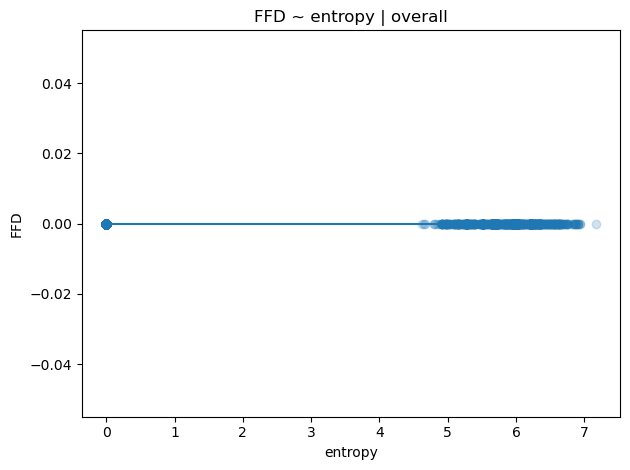

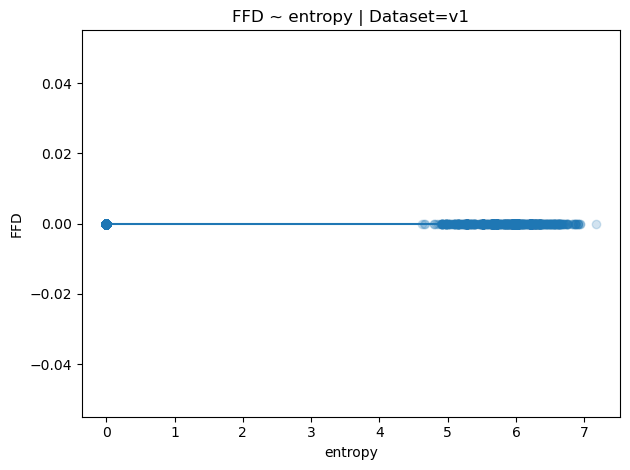

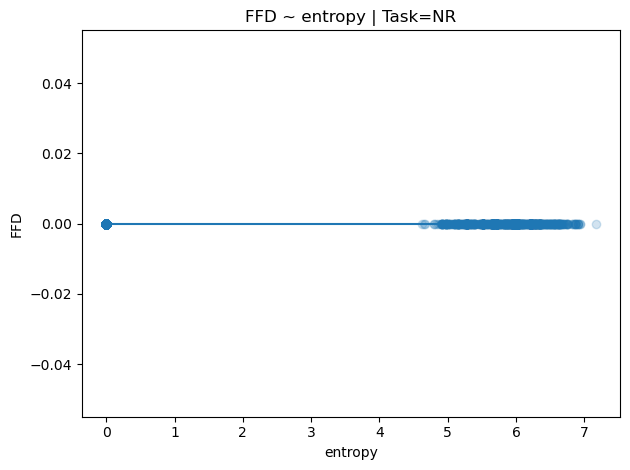

In [ ]:
def partial_plot(dfin, response='FFD', xvar='entropy', controls=None, fixed_cats=None, n_points=100, savepath=None):
    controls = controls or []; fixed_cats = fixed_cats or {}
    need=[response,xvar]+controls+list(fixed_cats.keys())
    if not set(need).issubset(dfin.columns): return
    formula=response+' ~ '+xvar
    if controls: formula+=' + '+' + '.join(controls)
    for k in fixed_cats:
        if k in dfin.columns and dfin[k].dtype=='O': formula+=f' + C({k})'
    mod=smf.ols(formula, data=dfin.dropna(subset=need)).fit()
    xgrid=np.linspace(dfin[xvar].quantile(0.05), dfin[xvar].quantile(0.95), n_points)
    base={c: float(dfin[c].median()) for c in controls}; base.update(fixed_cats)
    grid=pd.DataFrame({xvar:xgrid, **base}); yhat=mod.predict(grid)
    plt.figure(); samp=dfin.dropna(subset=need).sample(min(2000,len(dfin.dropna(subset=need))), random_state=SEED)
    plt.scatter(samp[xvar], samp[response], alpha=0.2); plt.plot(xgrid, yhat)
    ttl=', '.join([f"{k}={v}" for k,v in fixed_cats.items()]) if fixed_cats else 'overall'
    plt.title(f'{response} ~ {xvar} | {ttl}'); plt.xlabel(xvar); plt.ylabel(response); plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=150)
    plt.show()
if len(df)>0 and {'FFD','entropy'}.issubset(df.columns):
    controls=[c for c in ['length','log_freq'] if c in df.columns]
    partial_plot(df,'FFD','entropy',controls,{},savepath=Path('figures/metrics')/'F2_reading_vs_KEC.png')
    if 'Dataset' in df:
        for ds in sorted(df['Dataset'].dropna().unique()):
            dsd=df[df['Dataset']==ds]
            partial_plot(dsd,'FFD','entropy',controls,{'Dataset':ds},savepath=Path('figures/metrics')/f'F2_reading_vs_KEC_{ds}.png')
    if 'Task' in df:
        for tk in sorted(df['Task'].dropna().unique()):
            tkd=df[df['Task']==tk]
            partial_plot(tkd,'FFD','entropy',controls,{'Task':tk},savepath=Path('figures/metrics')/f'F2_reading_vs_KEC_task_{tk}.png')


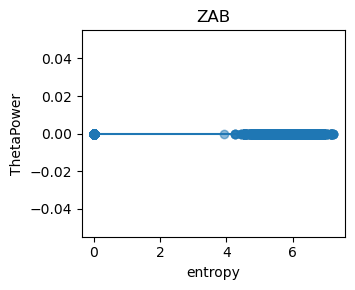

In [9]:
def per_subject_trends(dfin, eeg_col='ThetaPower', xvar='entropy', by='Dataset', saveprefix='F3_EEG_vs_KEC'):
    import math
    if not {'Subject',eeg_col,xvar}.issubset(dfin.columns): return
    groups=sorted(dfin[by].dropna().unique()) if (by and by in dfin.columns) else [None]
    for g in groups:
        dsub=dfin if g is None else dfin[dfin[by]==g]
        subs=sorted(dsub['Subject'].astype(str).unique()); nsub=len(subs)
        if nsub==0: continue
        ncols=4; nrows=int(math.ceil(nsub/ncols))
        plt.figure(figsize=(12,3*nrows))
        for i,s in enumerate(subs,1):
            ax=plt.subplot(nrows,ncols,i)
            sdf=dsub[dsub['Subject'].astype(str)==str(s)].dropna(subset=[eeg_col,xvar])
            if len(sdf)<5: ax.set_title(f'{s} (few)'); continue
            ax.scatter(sdf[xvar], sdf[eeg_col], alpha=0.3)
            try:
                m=smf.ols(f"{eeg_col} ~ {xvar}", data=sdf).fit(); xs=np.linspace(sdf[xvar].min(), sdf[xvar].max(), 50)
                ys=m.params['Intercept'] + m.params[xvar]*xs; ax.plot(xs, ys)
            except Exception: pass
            ax.set_title(str(s)); ax.set_xlabel(xvar); ax.set_ylabel(eeg_col)
        plt.tight_layout(); tag=f'_{by}_{g}' if g is not None else ''
        out=Path('figures/metrics')/f'{saveprefix}{tag}.png'; plt.savefig(out, dpi=150)
        plt.show()
if len(df)>0 and 'entropy' in df.columns and any(c in df.columns for c in ['ThetaPower','AlphaPower']):
    eegc='ThetaPower' if 'ThetaPower' in df.columns else 'AlphaPower'
    per_subject_trends(df, eeg_col=eegc, xvar='entropy', by='Dataset', saveprefix='F3_EEG_vs_KEC')


In [10]:
from statsmodels.regression.mixed_linear_model import MixedLM
def fit_mixedlm_ffd(dfin):
    req={'FFD','entropy','length','log_freq','Subject','SentenceID'}
    if not req.issubset(dfin.columns): return None
    use=['FFD','entropy','length','log_freq','Subject','SentenceID']
    if 'Task' in dfin.columns: use.append('Task')
    if 'Dataset' in dfin.columns: use.append('Dataset')
    mdf=dfin[use].dropna().copy()
    # dummies
    import pandas as pd
    for cat in ['Task','Dataset']:
        if cat in mdf.columns:
            dummies=pd.get_dummies(mdf[cat], prefix=cat, drop_first=True)
            mdf=pd.concat([mdf.drop(columns=[cat]), dummies], axis=1)
    exog_cols=[c for c in mdf.columns if c not in ['FFD','Subject','SentenceID']]
    exog=sm.add_constant(mdf[exog_cols]); endog=mdf['FFD']
    vc={'Sentence': '0 + C(SentenceID)'}
    try:
        model=MixedLM(endog, exog, groups=mdf['Subject'], vc_formula=vc)
        res=model.fit(reml=True, method='lbfgs')
        Path('data/processed')/'mixedlm_ffd_summary.txt'
        (Path('data/processed')/'mixedlm_ffd_summary.txt').write_text(str(res.summary()))
        print('Saved MixedLM summary')
        return res
    except Exception as e:
        warnings.warn(f'MixedLM failed: {e}'); return None
# Uncomment to run: _=fit_mixedlm_ffd(df)


In [11]:
from joblib import Parallel, delayed
def _boot_fit_once(groups, dfin, formula, rng):
    samp_groups=rng.choice(groups, size=len(groups), replace=True)
    import pandas as pd
    samp_df=pd.concat([dfin[dfin['Subject']==g] for g in samp_groups], ignore_index=True)
    try:
        m=smf.ols(formula, data=samp_df).fit(); return m.params
    except Exception: return None
def bootstrap_coefs_parallel(dfin, formula, group_col='Subject', B=1000, n_jobs=-1, seed=42):
    rng=np.random.default_rng(seed); groups=dfin[group_col].unique()
    seeds=rng.integers(0, 2**32-1, size=B, endpoint=True)
    res=Parallel(n_jobs=n_jobs, verbose=10)(delayed(_boot_fit_once)(groups, dfin, formula, np.random.default_rng(int(s))) for s in seeds)
    import pandas as pd
    return pd.DataFrame([r for r in res if r is not None])
# Example:
# if len(df)>0 and {'FFD','entropy','length','log_freq','Subject'}.issubset(df.columns):
#     boot=bootstrap_coefs_parallel(df[['FFD','entropy','length','log_freq','Subject']].dropna(),'FFD ~ entropy + length + log_freq',B=1000,n_jobs=-1)
#     boot.to_csv(Path('data/processed')/'boot_ols_ffd_entropy.csv', index=False)
#     print('Saved bootstrap')


In [12]:
%pip install joblib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [14]:
import json
qa={'timestamp_utc':'2025-09-01T19:48:51.873406Z',
    'merged_rows': int(len(df)) if len(df)>0 else 0,
    'et_cols': [c for c in ('FFD','GD','log_TRT','log_GPT') if c in (df.columns if len(df)>0 else [])],
    'kec_cols':[c for c in ('entropy','curvature','coherence') if c in (df.columns if len(df)>0 else [])],
    'cat_covs':[c for c in ('Dataset','Task') if c in (df.columns if len(df)>0 else [])],
    'reading_coeffs_csv': str(PROC_DIR/'models_reading_coeffs.csv') if (PROC_DIR/'models_reading_coeffs.csv').exists() else None,
    'reading_coeffs_fdr_csv': str(PROC_DIR/'models_reading_coeffs_fdr.csv') if (PROC_DIR/'models_reading_coeffs_fdr.csv').exists() else None,
    'mixedlm_summary': str(PROC_DIR/'mixedlm_ffd_summary.txt') if (PROC_DIR/'mixedlm_ffd_summary.txt').exists() else None,
    'fig_f2': [str(p) for p in Path('figures/metrics').glob('F2_reading_vs_KEC*.png')],
    'fig_f3': [str(p) for p in Path('figures/metrics').glob('F3_EEG_vs_KEC*.png')]
}
(Path('reports')/'qa_kec_models.json').write_text(json.dumps(qa, indent=2))
print('Saved QA')


Saved QA
